In [1]:
%load_ext autoreload
%autoreload 2

import poisson_atac as patac
import scanpy as sc

import scipy.sparse
from pytorch_lightning.loggers import WandbLogger
import wandb
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import seml
import os

Global seed set to 0
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/sacred/config/custom_containers.py:273: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if hasattr(np, npf):
/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/sacred/config/custom_containers.py:274: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdo

In [2]:
from utils import plot_embedding, load_experiment, compute_embedding

In [3]:
from poisson_atac.seml import evaluation_table, evaluate_embedding, evaluate_test_cells

In [4]:
sns.set_style("whitegrid")

In [5]:
fig_path = '/storage/groups/ml01/workspace/laura.martens/atac_poisson_data/panels/Figure2'

In [6]:
data_path = "/storage/groups/ml01/workspace/laura.martens/neurips_challenge/data/phase2-private-data/predict_modality/openproblems_bmmc_multiome_phase2_rna"

In [7]:
adata = patac.data.load_neurips(gex=True, batch=None, only_train = False)

In [8]:
adata_train = adata[adata.obs.is_train].copy()
adata_test = adata[~adata.obs.is_train].copy()

In [11]:
test = sc.read(os.path.join(data_path, 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_test_mod2.h5ad'))

Only considering the two last: ['.output_test_mod2', '.h5ad'].
Only considering the two last: ['.output_test_mod2', '.h5ad'].


In [14]:
test.var_names

Index(['chr1-912570-913458', 'chr1-1115800-1116696', 'chr1-1273488-1274400',
       'chr1-1758574-1759450', 'chr1-1778345-1779150', 'chr1-1856926-1857817',
       'chr1-1860680-1861564', 'chr1-2114993-2115779', 'chr1-2126835-2127720',
       'chr1-2152812-2153628',
       ...
       'chrX-154347004-154347877', 'chrX-154378553-154379478',
       'chrX-154400877-154401779', 'chrX-154737740-154738630',
       'chrX-154784013-154784926', 'chrX-154800543-154801388',
       'chrX-155094214-155095119', 'chrX-156001265-156002117',
       'GL000219.1-90062-90937', 'KI270726.1-27152-28034'],
      dtype='object', length=10000)

In [10]:
os.listdir(data_path)

['openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_test_mod1.h5ad',
 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_train_mod2.h5ad',
 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_train_mod1.h5ad',
 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_test_mod2.h5ad']

# Evaluate model

In [15]:
results = seml.get_results('atac_atac_prediction_counts', to_data_frame=True,  fields=["config", "config_hash", "result", "batch_id"],)
results['config.data.batch'][results['config.data.batch'].apply(isinstance,args = [list])] = 'all'
results['config.data.batch'][results['config.data.batch'].isna()] = 'hematopoiesis'
results['config.model.model_type'][results['config.data.dataset'] == "neurips_count"] = "cistopic_count"
neurips = results[results['config.data.batch'] != 'hematopoiesis']
data = neurips[neurips.batch_id == 7]

  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

/tmp/ipykernel_48299/3215479661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['config.data.batch'][results['config.data.batch'].apply(isinstance,args = [list])] = 'all'
/tmp/ipykernel_48299/3215479661.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['config.data.batch'][results['config.data.batch'].isna()] = 'hematopoiesis'
/tmp/ipykernel_48299/3215479661.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resu

In [16]:
#choosing model with n_latent = 110 since it has the best rmse
data

,_id,batch_id,config_hash,config.overwrite,config.db_collection,config.data.batch,config.data.dataset,config.model.model_type,config.optimization.regularization.learning_rate,config.optimization.regularization.weight_decay,...,result.rmse,result.bce,result.nmi,result.ari,result.model_path,config.setup.model_params.n_latent,config.setup.model_params.n_hidden,config.setup.model_params.use_layer_norm,config.setup.model_params.normalize,config.setup.model_params.pretrain
163,221,7,d633bcf63d28c0b0d7ca21ca15e21fbf,221,atac_atac_prediction_counts,all,neurips_multiome,gex,0.0001,0.001,...,0.154194,10836.257002,0.770878,0.699945,/storage/groups/ml01/workspace/laura.martens/a...,80.0,150.0,encoder,NaN,NaN
164,222,7,d2d0ae86bf6d64e85b8a05667db55901,222,atac_atac_prediction_counts,all,neurips_multiome,gex,0.0001,0.001,...,0.154191,10835.157449,0.760052,0.701706,/storage/groups/ml01/workspace/laura.martens/a...,100.0,150.0,encoder,NaN,NaN
165,223,7,542e9f7877dd0753798cad3d9e475907,223,atac_atac_prediction_counts,all,neurips_multiome,gex,0.0001,0.001,...,0.154188,10834.152977,0.759442,0.664569,/storage/groups/ml01/workspace/laura.martens/a...,110.0,150.0,encoder,NaN,NaN
166,224,7,357e5a245b1670f83254681b9bec2c95,224,atac_atac_prediction_counts,all,neurips_multiome,gex,0.0001,0.001,...,0.154189,10833.969405,0.758291,0.661050,/storage/groups/ml01/workspace/laura.martens/a...,130.0,150.0,encoder,NaN,NaN


## Load Poisson Model

In [17]:
model_hash="542e9f7877dd0753798cad3d9e475907"
seml_collection = 'atac_atac_prediction_counts'

In [18]:
ex, model, config = load_experiment(seml_collection, model_hash)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

get_experiment


2022-03-14 20:19:53 (INFO): Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2022-03-14 20:19:53 (INFO): Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


INFO     Generating sequential column names                                                  


2022-03-14 20:19:53 (INFO): Generating sequential column names


13431
GEXTOATACVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=13431, out_features=150, bias=True)
          (1): None
          (2): LayerNorm((150,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=150, out_features=150, bias=True)
          (1): None
          (2): LayerNorm((150,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=150, out_features=110, bias=True)
    (var_encoder): Linear(in_features=150, out_features=110, bias=True)
  )
  (decoder): LinearDecoderSCVI(
    (factor_regressor): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_fe

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

13431


In [61]:
X_emb = model.get_latent_representation(adata)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


2022-03-09 12:49:57 (INFO): Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup


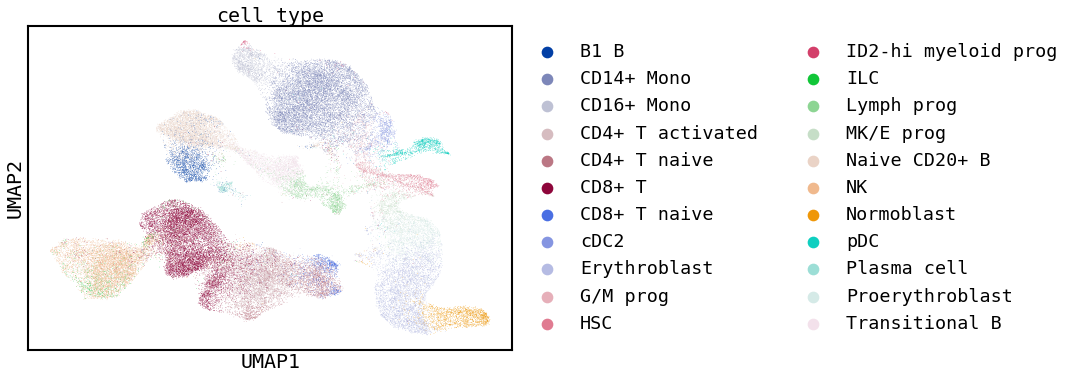

In [62]:
compute_embedding(adata, X_emb)
sc.pl.umap(adata, color = config['setup']['label_key'])

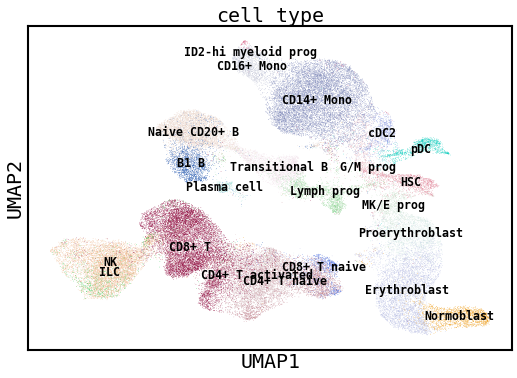

In [63]:
sc.pl.umap(adata, color = config['setup']['label_key'], legend_loc = "on data", legend_fontsize="xx-small")

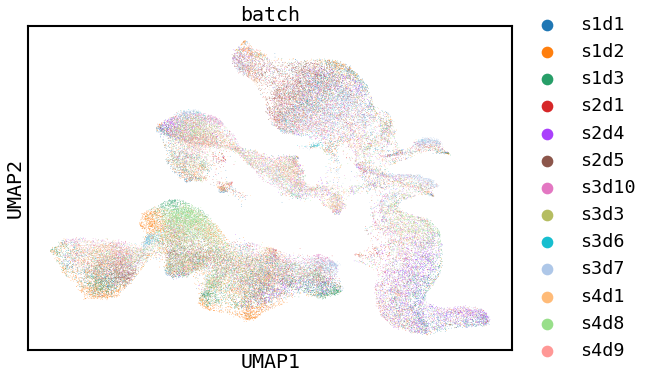

In [64]:
sc.pl.umap(adata, color = "batch")

In [69]:
adata.obs.is_train = adata.obs.is_train.astype(str)

/home/icb/laura.martens/miniconda3/envs/poisson_atac_new/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'is_train' as categorical


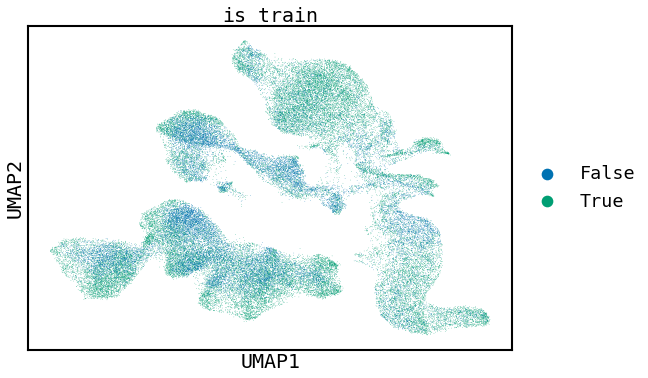

In [70]:
sc.pl.umap(adata, color = "is_train")

In [19]:
y_median = model.get_normalized_accessibility(adata_test, library = ex.adata[ex.adata.obs.is_train].obs.size_factor.median())
y_pred = model.get_accessibility_estimates(adata_test, return_numpy= True)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


2022-03-14 20:20:01 (INFO): Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup


In [34]:
n_cells=1000
n_peaks=10000

In [36]:
neurips_test = y_pred[adata_test.obs_names.isin(test.obs_names), :][:, adata_test.var_names.isin(test.var_names)]
neurips_test_median = y_median[adata_test.obs_names.isin(test.obs_names), :][:, adata_test.var_names.isin(test.var_names)]

In [43]:
y_true = adata_test[adata_test.obs_names.isin(test.obs_names),adata_test.var_names.isin(test.var_names)].X.A
predictions = {'Poisson\ntrue size factor': neurips_test, 'Poisson\nmedian size factor': neurips_test_median}
results_df = [evaluation_table(y_true, predictions)]

In [44]:
results_df

[                   Poisson\ntrue size factor  Poisson\nmedian size factor
 average_precision                   0.287282                     0.212917
 auroc                               0.886353                     0.864503
 rmse                                0.173259                     0.178192
 bce                              1140.011000                  1234.316125]

In [45]:
np.random.seed(18)
for i in range(4):
    print(i)
    random_peaks = np.random.choice(np.arange(adata_test.shape[1]), n_peaks)
    random_cells = np.random.choice(np.arange(adata_test.shape[0]), n_cells)
    y_true = adata_test[random_cells, random_peaks].X.A
    predictions = {'Poisson\ntrue size factor': y_pred[random_cells, :][:,random_peaks], 'Poisson\nmedian size factor': y_median[random_cells, :][:,random_peaks]}
    results_df.append(evaluation_table(y_true, predictions))

results = pd.concat(results_df)

# from https://eval.ai/web/challenges/challenge-page/1111/leaderboard/2860/GEX2ATAC
results["LS_Labs"] = pd.Series({'auroc': np.nan, 'average_precision': np.nan, 'bce': np.nan, "rmse": 0.1774})
results["QCM1"] = pd.Series({'auroc': np.nan, 'average_precision': np.nan, 'bce': np.nan, "rmse": 0.1775})
results["GLUE\n(CLUE)"] = pd.Series({'auroc': np.nan, 'average_precision': np.nan, 'bce': np.nan, "rmse": 0.1775})
#results.to_csv(os.path.join(fig_path, "neurips_eval.csv"))

0
1
2
3


In [50]:
results

,Poisson\ntrue size factor,Poisson\nmedian size factor,LS_Labs,QCM1,GLUE\n(CLUE)
average_precision,0.287282,0.212917,NaN,NaN,NaN
auroc,0.886353,0.864503,NaN,NaN,NaN
rmse,0.173259,0.178192,0.1774,0.1775,0.1775
bce,1140.011000,1234.316125,NaN,NaN,NaN
average_precision,0.287024,0.212721,NaN,NaN,NaN
auroc,0.891478,0.869466,NaN,NaN,NaN
rmse,0.169680,0.174366,0.1774,0.1775,0.1775
bce,1093.086750,1178.750500,NaN,NaN,NaN
average_precision,0.292907,0.217109,NaN,NaN,NaN
auroc,0.893896,0.873474,NaN,NaN,NaN


In [47]:
sns_df=results.loc['rmse'].melt(var_name = "Model", value_name = "rmse")

In [49]:
sns_df

,Model,rmse
0,Poisson\ntrue size factor,0.173259
1,Poisson\ntrue size factor,0.169680
2,Poisson\ntrue size factor,0.170863
3,Poisson\ntrue size factor,0.169806
4,Poisson\ntrue size factor,0.168026
5,Poisson\nmedian size factor,0.178192
6,Poisson\nmedian size factor,0.174366
7,Poisson\nmedian size factor,0.175691
8,Poisson\nmedian size factor,0.174462
9,Poisson\nmedian size factor,0.172486


<AxesSubplot:xlabel='rmse', ylabel='Model'>

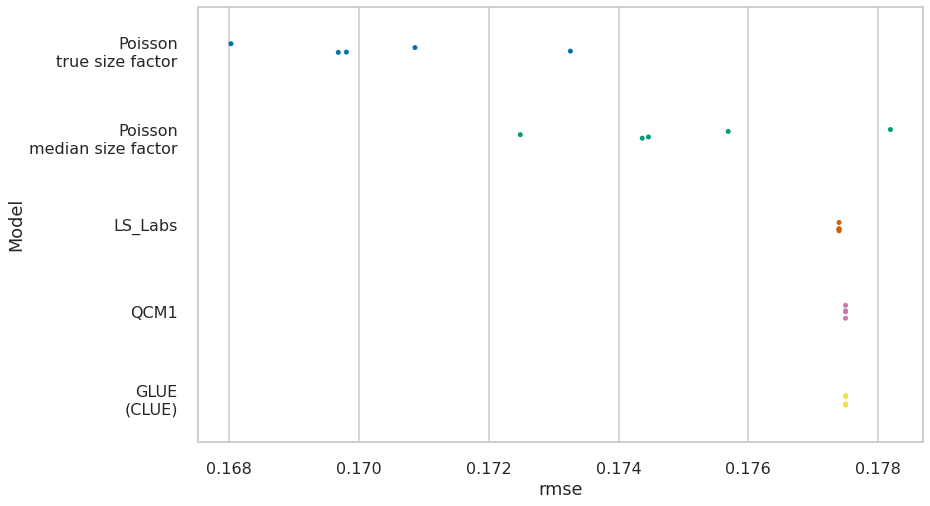

In [54]:
fig, ax = plt.subplots(figsize=(13,8))
sns.stripplot(data=sns_df, y = "Model", x ="rmse", ax=ax, orient="h")
#plt.ylim((0, 0.18))

## Load Peakvi Model

In [8]:
results = seml.get_results('atac_atac_prediction_counts', to_data_frame=True,  fields=["config", "config_hash", "result", "batch_id"],)

  0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

In [9]:
results[results["batch_id"] ==12]

,_id,batch_id,config_hash,config.overwrite,config.db_collection,config.data.batch,config.data.dataset,config.model.model_type,config.optimization.regularization.learning_rate,config.optimization.regularization.weight_decay,...,result.rmse,result.bce,result.nmi,result.ari,result.model_path,config.setup.model_params.n_latent,config.setup.model_params.n_hidden,config.setup.model_params.use_layer_norm,config.setup.model_params.normalize,config.setup.model_params.pretrain
280,345,12,ec060da3ffc3eb9f7ac71c40f48f9204,345,atac_atac_prediction_counts,"[s1d1, s1d2, s1d3, s2d1, s2d5, s3d10, s3d3, s3...",neurips_multiome,gex_binary,0.0001,0.001,...,0.157569,11510.717816,0.777072,0.698949,/storage/groups/ml01/workspace/laura.martens/a...,80.0,150.0,encoder,NaN,NaN
281,346,12,e0a03270b313dd07ab5db1418280d1eb,346,atac_atac_prediction_counts,"[s1d1, s1d2, s1d3, s2d1, s2d5, s3d10, s3d3, s3...",neurips_multiome,gex_binary,0.0001,0.001,...,0.157575,11508.162862,0.771153,0.693876,/storage/groups/ml01/workspace/laura.martens/a...,100.0,150.0,encoder,NaN,NaN
282,347,12,53535cc186f7d3e952d793d71fa98110,347,atac_atac_prediction_counts,"[s1d1, s1d2, s1d3, s2d1, s2d5, s3d10, s3d3, s3...",neurips_multiome,gex_binary,0.0001,0.001,...,0.157636,11518.711226,0.773513,0.698184,/storage/groups/ml01/workspace/laura.martens/a...,110.0,150.0,encoder,NaN,NaN
283,348,12,982918796278f65fbdb795dfec8b5ba9,348,atac_atac_prediction_counts,"[s1d1, s1d2, s1d3, s2d1, s2d5, s3d10, s3d3, s3...",neurips_multiome,gex_binary,0.0001,0.001,...,0.157563,11504.610026,0.769081,0.702245,/storage/groups/ml01/workspace/laura.martens/a...,130.0,150.0,encoder,NaN,NaN


In [10]:
results[results["batch_id"] ==7]

,_id,batch_id,config_hash,config.overwrite,config.db_collection,config.data.batch,config.data.dataset,config.model.model_type,config.optimization.regularization.learning_rate,config.optimization.regularization.weight_decay,...,result.rmse,result.bce,result.nmi,result.ari,result.model_path,config.setup.model_params.n_latent,config.setup.model_params.n_hidden,config.setup.model_params.use_layer_norm,config.setup.model_params.normalize,config.setup.model_params.pretrain
163,221,7,d633bcf63d28c0b0d7ca21ca15e21fbf,221,atac_atac_prediction_counts,"[s1d1, s1d2, s1d3, s2d1, s2d5, s3d10, s3d3, s3...",neurips_multiome,gex,0.0001,0.001,...,0.154194,10836.257002,0.770878,0.699945,/storage/groups/ml01/workspace/laura.martens/a...,80.0,150.0,encoder,NaN,NaN
164,222,7,d2d0ae86bf6d64e85b8a05667db55901,222,atac_atac_prediction_counts,"[s1d1, s1d2, s1d3, s2d1, s2d5, s3d10, s3d3, s3...",neurips_multiome,gex,0.0001,0.001,...,0.154191,10835.157449,0.760052,0.701706,/storage/groups/ml01/workspace/laura.martens/a...,100.0,150.0,encoder,NaN,NaN
165,223,7,542e9f7877dd0753798cad3d9e475907,223,atac_atac_prediction_counts,"[s1d1, s1d2, s1d3, s2d1, s2d5, s3d10, s3d3, s3...",neurips_multiome,gex,0.0001,0.001,...,0.154188,10834.152977,0.759442,0.664569,/storage/groups/ml01/workspace/laura.martens/a...,110.0,150.0,encoder,NaN,NaN
166,224,7,357e5a245b1670f83254681b9bec2c95,224,atac_atac_prediction_counts,"[s1d1, s1d2, s1d3, s2d1, s2d5, s3d10, s3d3, s3...",neurips_multiome,gex,0.0001,0.001,...,0.154189,10833.969405,0.758291,0.661050,/storage/groups/ml01/workspace/laura.martens/a...,130.0,150.0,encoder,NaN,NaN


In [ ]:
model_hash="982918796278f65fbdb795dfec8b5ba9"
seml_collection = 'atac_atac_prediction_counts'

In [ ]:
ex, model, config = load_experiment(seml_collection, model_hash)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

get_experiment


2022-03-11 08:50:44 (INFO): Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2022-03-11 08:50:46 (INFO): Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


INFO     Generating sequential column names                                                  


2022-03-11 08:50:46 (INFO): Generating sequential column names


BinaryGEXTOATACVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=13431, out_features=150, bias=True)
          (1): None
          (2): LayerNorm((150,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=150, out_features=150, bias=True)
          (1): None
          (2): LayerNorm((150,), eps=1e-05, elementwise_affine=False)
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=150, out_features=130, bias=True)
    (var_encoder): Linear(in_features=150, out_features=130, bias=True)
  )
  (z_decoder): Decoder(
    (px_decoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=130, ou

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
X_emb = model.get_latent_representation(adata)

In [ ]:
compute_embedding(adata, X_emb)
sc.pl.umap(adata, color = config['setup']['label_key'])

In [ ]:
sc.pl.umap(adata, color = config['setup']['label_key'], legend_loc = "on data", legend_fontsize="xx-small")

In [ ]:
sc.pl.umap(adata, color = "batch")

In [ ]:
adata.obs.is_train = adata.obs.is_train.astype(str)

In [ ]:
sc.pl.umap(adata, color = "is_train")

In [ ]:
if True:
    y_pred = model.get_accessibility_estimates(adata_test, return_numpy= True, normalize_cells=True, normalize_regions=True)

    np.random.seed(18)
    results_df = []
    for i in range(5):
        print(i)
        random_peaks = np.random.choice(np.arange(adata_test.shape[0]), 10000)
        y_true = adata_test[:, random_peaks].X.A
        predictions = {'Binary model': y_pred[:, random_peaks]}
        results_df.append(evaluation_table(y_true, predictions))

    results = pd.concat(results_df)
    results.to_csv(os.path.join(fig_path, "neurips_eval_binary.csv"))

0


## Make the plot

In [31]:
results_binary = pd.read_csv(os.path.join(fig_path, "neurips_eval_binary.csv"), index_col=0)

In [32]:
results_count = pd.read_csv(os.path.join(fig_path, "neurips_eval.csv"), index_col=0)

In [38]:
results = pd.concat([results_binary, results_count])

In [39]:
results

,Binary model,Poisson\ntrue size factor,Poisson\nmedian size factor,LS_Labs,QCM1,GLUE\n(CLUE)
auroc,0.866316,NaN,NaN,NaN,NaN,NaN
average_precision,0.205522,NaN,NaN,NaN,NaN,NaN
bce,1219.514419,NaN,NaN,NaN,NaN,NaN
rmse,0.175466,NaN,NaN,NaN,NaN,NaN
auroc,0.867653,NaN,NaN,NaN,NaN,NaN
average_precision,0.213489,NaN,NaN,NaN,NaN,NaN
bce,1244.600330,NaN,NaN,NaN,NaN,NaN
rmse,0.177860,NaN,NaN,NaN,NaN,NaN
auroc,0.867199,NaN,NaN,NaN,NaN,NaN
average_precision,0.204866,NaN,NaN,NaN,NaN,NaN


In [40]:
sns_df=results.loc['rmse'].melt(var_name = "Model", value_name = "rmse")

In [ ]:
"encoder-decoder\npoisson (true size factor)" "encoder-decoder\npoission (median size factor)" "encoder-decoder\npoission (binary)", in der reihenfolge nennen? binary zwischen poisson and ref models zu platzieren oder?

oder alternative sowas wie "our model\npoission (true size factor)"

In [50]:
model_name_dict = {
    'Binary model': "encoder-decoder\n(binary)", 
    'Poisson\ntrue size factor': "encoder-decoder\npoisson (true size factor)",
    'Poisson\nmedian size factor': "encoder-decoder\npoisson (median size factor)", 
    'LS_Labs': "LS_Labs\n(binary)", 
    'QCM1': "QCM1\n(binary)", 
    'GLUE\n(CLUE)':'GLUE\n(CLUE)\n(binary)' 
}

In [55]:
model_name_dict.values()

dict_values(['encoder-decoder\n(binary)', 'encoder-decoder\npoisson (true size factor)', 'encoder-decoder\npoisson (median size factor)', 'LS_Labs\n(binary)', 'QCM1\n(binary)', 'GLUE\n(CLUE)\n(binary)'])

In [52]:
sns_df.Model = sns_df.Model.map(model_name_dict)

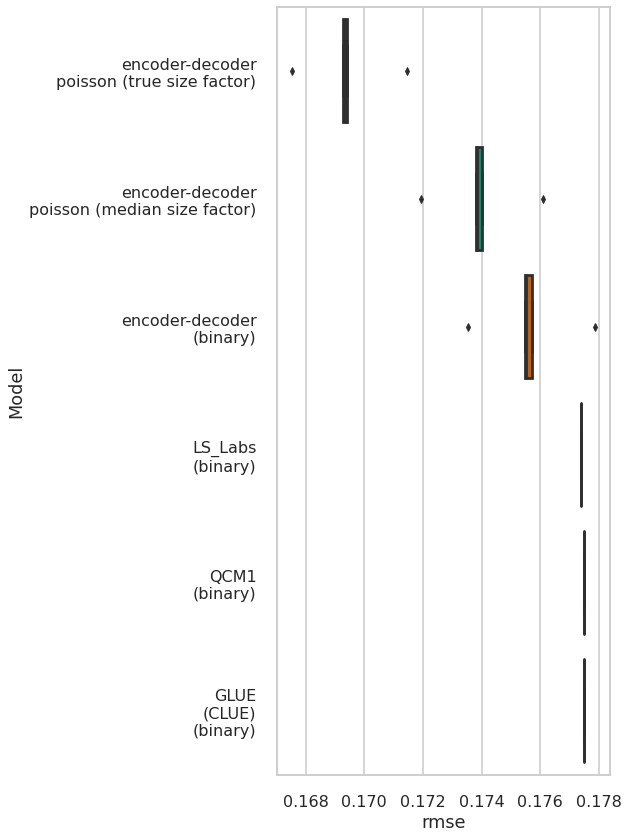

In [56]:
fig, ax = plt.subplots(figsize=(9,12))
sns.boxplot(data=sns_df, y = "Model", x ="rmse", ax=ax, orient="h", order = ['encoder-decoder\npoisson (true size factor)', 'encoder-decoder\npoisson (median size factor)', 'encoder-decoder\n(binary)','LS_Labs\n(binary)', 'QCM1\n(binary)', 'GLUE\n(CLUE)\n(binary)'] )
plt.tight_layout()
plt.savefig(os.path.join(fig_path, "neurips_eval.pdf"))

<AxesSubplot:xlabel='rmse', ylabel='Model'>

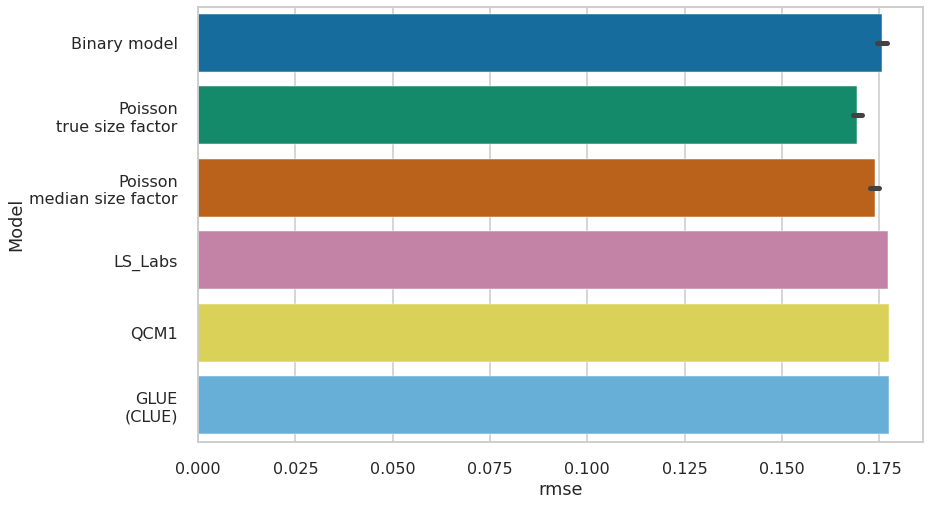

In [42]:
fig, ax = plt.subplots(figsize=(13,8))
sns.barplot(data=sns_df, y = "Model", x ="rmse", ax=ax, orient="h")

# TODO
* SOLVE how to train on unseen batches (OR train without batches!)
* SOLVE docker??
* Swap mean with median